# Baisc Simulations

## Package Prerequisites

Import Packages

In [3]:
# QubiC toolchain for compiling circuits
import qubic.toolchain as tc
# QubiC configuration management libraries
import qubitconfig.qchip as qc
from distproc.hwconfig import FPGAConfig, load_channel_configs
# other packages
import numpy as np
import matplotlib.pyplot as plt 
# import the compiler flags
from distproc.compiler import CompilerFlags

Config FPGA and Channels

In [4]:
fpga_config = FPGAConfig()
channel_configs = load_channel_configs('channel_config_hw.json')

## Pulse Simulation

### Single Pulse

Program the pulse parameters

In [5]:
circuit = [
    #play a single pulse on the Q0 drive channel
    {'name': 'pulse', 'phase': 0, 'freq': 4944383311, 'amp': 0.334704954261188, 'twidth': 2.4e-08,
     'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
     'dest': 'Q0.qdrv'}, 
    
] 

Compile and assemble the pulse program

In [6]:
# CompilerFlags can be set using an instance or dictionary.
# are programming at the pulse level only.
compiled_prog = tc.run_compile_stage(circuit, fpga_config, None, compiler_flags={'resolve_gates': False})
compiled_prog = tc.run_compile_stage(circuit, fpga_config, None, compiler_flags=CompilerFlags(resolve_gates=False))
compiled_prog.program 

{('Q0.qdrv', 'Q0.rdrv', 'Q0.rdlo'): [{'op': 'phase_reset'},
  {'op': 'pulse',
   'freq': 4944383311,
   'phase': 0,
   'amp': 0.334704954261188,
   'env': {'env_func': 'cos_edge_square',
    'paradict': {'ramp_fraction': 0.25, 'twidth': 2.4e-08}},
   'start_time': 5,
   'dest': 'Q0.qdrv'},
  {'op': 'done_stb'}]}

In [7]:
asm_prog = tc.run_assemble_stage(compiled_prog, channel_configs) 

Use simulator to run the pulse program

In [8]:
import sim_client as sc
client = sc.SimClient() 
# send our program to the simulator, and run it for 150 ns
client.run_program(asm_prog, sim_time=150.e-9) 

In [9]:
channel_configs['Q0.qdrv'].core_ind 

7

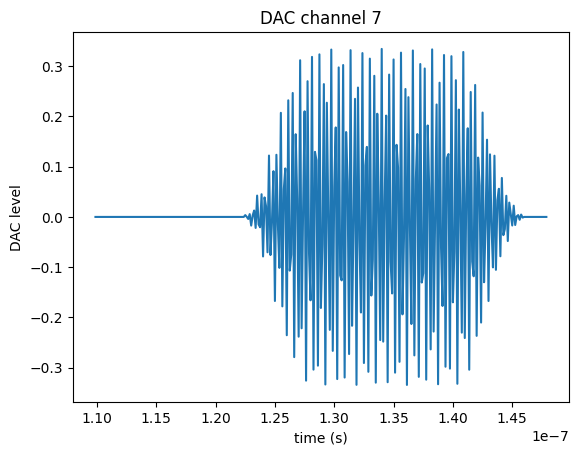

In [10]:
# plot the output of DAC channel 7, from t = 110 ns to t = 150 ns (relative to the start of the simulation)
client.plot_dac_out(channel_configs['Q0.qdrv'].core_ind, 110.e-9, 150.e-9) 

### Multiple Pulses

In [11]:
circuit = [
    #play two pulses on the Q0 drive channel
    {'name': 'pulse', 'phase': 0, 'freq': 4944383311, 'amp': 0.3, 'twidth': 2.4e-08,
     'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
     'dest': 'Q0.qdrv'}, 
    
    {'name': 'pulse', 'phase': 0, 'freq': 4944383311, 'amp': 0.6, 'twidth': 2.4e-08,
     'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
     'dest': 'Q0.qdrv'}
    
] 

In [12]:
compiled_prog = tc.run_compile_stage(circuit, fpga_config, None, compiler_flags={'resolve_gates': False})
asm_prog = tc.run_assemble_stage(compiled_prog, channel_configs) 

In [13]:
client.run_program(asm_prog, sim_time=200.e-9) 

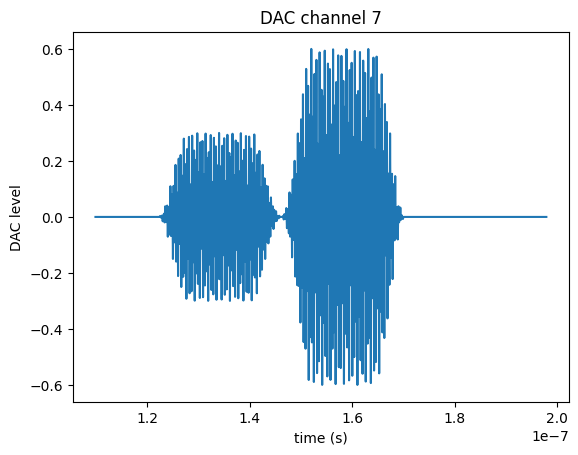

In [14]:
client.plot_dac_out(7, 110.e-9, 200.e-9) 

### Pulse on Different Channels

In [15]:
circuit = [
    # play two pulses on the Q0 drive channel
    {'name': 'pulse', 'phase': 0, 'freq': 4944383311, 'amp': 0.3, 'twidth': 2.4e-08,
     'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
     'dest': 'Q0.qdrv'}, 
    
    {'name': 'pulse', 'phase': 0, 'freq': 4944383311, 'amp': 0.6, 'twidth': 2.4e-08,
     'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
     'dest': 'Q0.qdrv'},
    
    # add a single pulse on Q1 drive -- this will be scheduled immediately, and played in parallel with the first Q0 pulse
    {'name': 'pulse', 'phase': 0, 'freq': 4944383311, 'amp': 0.6, 'twidth': 2.4e-08,
     'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
     'dest': 'Q1.qdrv'}
    
] 

In [16]:
compiled_prog = tc.run_compile_stage(circuit, fpga_config, None, compiler_flags={'resolve_gates': False})
asm_prog = tc.run_assemble_stage(compiled_prog, channel_configs) 

In [17]:
client.run_program(asm_prog, sim_time=200.e-9) 

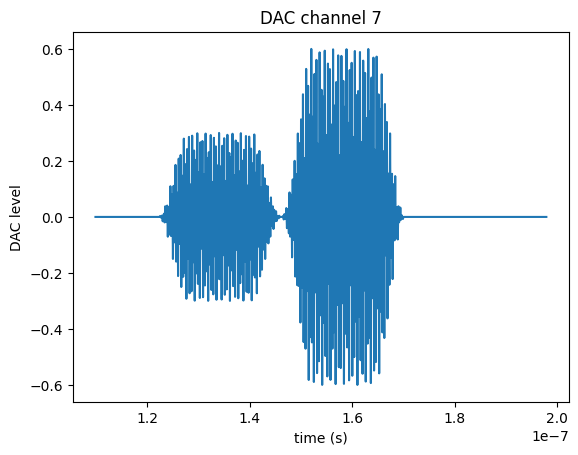

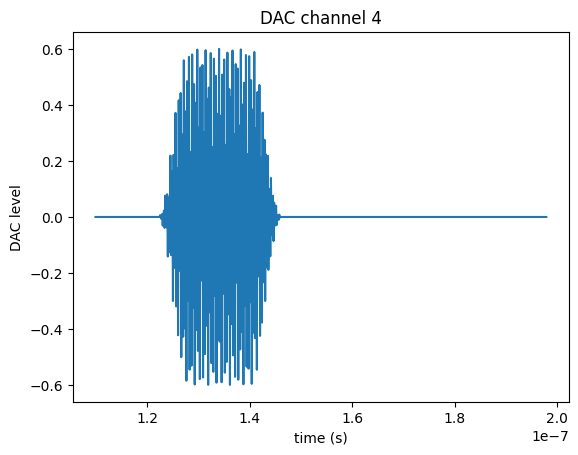

In [18]:
client.plot_dac_out(channel_configs['Q0.qdrv'].core_ind, 110.e-9, 200.e-9)
client.plot_dac_out(channel_configs['Q1.qdrv'].core_ind, 110.e-9, 200.e-9) 

### Delay and Barriers

In [19]:
circuit = [
    #play two pulses on the Q0 drive channel
    {'name': 'pulse', 'phase': 0, 'freq': 4944383311, 'amp': 0.3, 'twidth': 2.4e-08,
     'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
     'dest': 'Q0.qdrv'}, 
    
    {'name': 'delay', 't': 50.e-9},
    
    {'name': 'pulse', 'phase': 0, 'freq': 4944383311, 'amp': 0.6, 'twidth': 2.4e-08,
     'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
     'dest': 'Q0.qdrv'},
    
    {'name': 'barrier'}, 
    
    {'name': 'pulse', 'phase': 0, 'freq': 4944383311, 'amp': 0.6, 'twidth': 2.4e-08,
     'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
     'dest': 'Q1.qdrv'}
    
] 

In [20]:
compiled_prog = tc.run_compile_stage(circuit, fpga_config, None, compiler_flags={'resolve_gates': False})
asm_prog = tc.run_assemble_stage(compiled_prog, channel_configs)

In [21]:
client.run_program(asm_prog, sim_time=500.e-9)

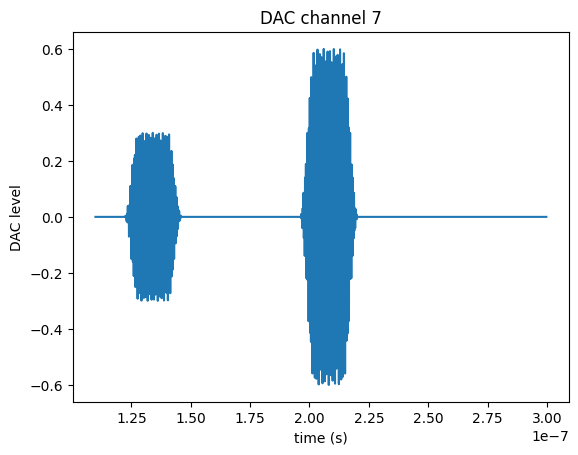

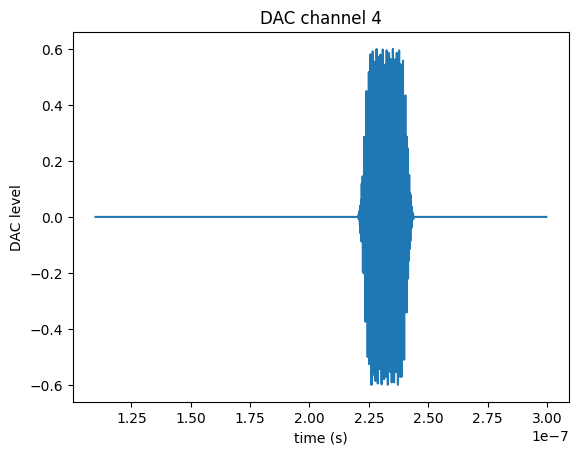

In [22]:
client.plot_dac_out(channel_configs['Q0.qdrv'].core_ind, 110.e-9, 300.e-9)
client.plot_dac_out(channel_configs['Q1.qdrv'].core_ind, 110.e-9, 300.e-9) 

## Gates Simulation

### X90 Gate

In [23]:
circuit = [
    # this circuit plays calibrated X90 gates
    {'name': 'X90', 'qubit': 'Q0'},
    {'name': 'X90', 'qubit': 'Q1'}] 

In [24]:
# load in configuration from qubitcfg.json
qchip = qc.QChip('qubitcfg_hw.json') 

In [25]:
# link the qchip configuration at compile time
compiled_prog = tc.run_compile_stage(circuit, fpga_config, qchip)
asm_prog = tc.run_assemble_stage(compiled_prog, channel_configs) 

In [26]:
client.run_program(asm_prog, sim_time=500.e-9)

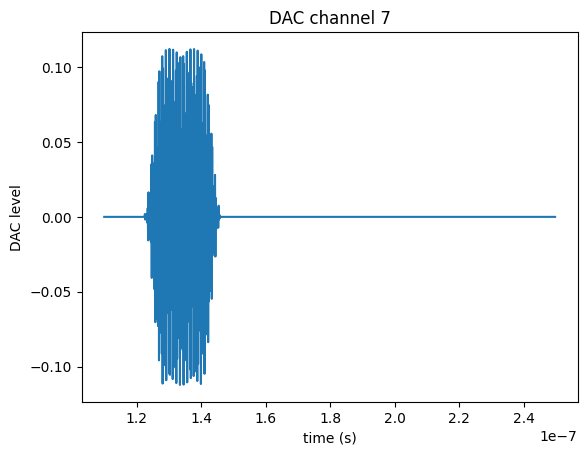

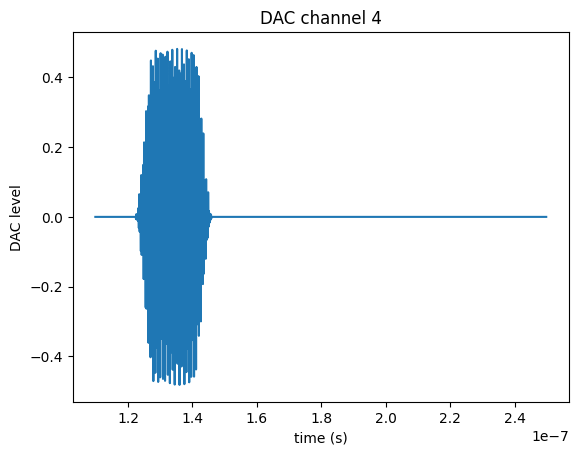

In [27]:
client.plot_dac_out(channel_configs['Q0.qdrv'].core_ind, 110.e-9, 250.e-9)
client.plot_dac_out(channel_configs['Q1.qdrv'].core_ind, 110.e-9, 250.e-9) 

### Single pulse on readout channel

In [28]:
circuit = [{'name': 'pulse', 'phase': 0, 'freq': 6.1e9, 'amp': 0.6, 'twidth': 1e-07,
     'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
     'dest': 'Q0.rdrv'}] 

In [29]:
compiled_prog = tc.run_compile_stage(circuit, fpga_config, None, compiler_flags={'resolve_gates': False})
asm_prog = tc.run_assemble_stage(compiled_prog, channel_configs) 

In [30]:
client.run_program(asm_prog, sim_time=500.e-9) 

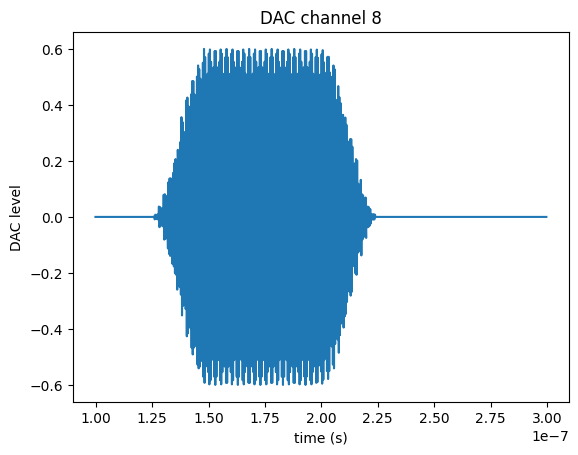

In [31]:
client.plot_dac_out(8, 100.e-9, 300.e-9) 

### Multiple pulses on readout channel

In [32]:
circuit = [{'name': 'pulse', 'phase': 0, 'freq': 6.1e9, 'amp': 0.4, 'twidth': 1e-07,
     'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
     'dest': 'Q0.rdrv'},
           {'name': 'pulse', 'phase': 0, 'freq': 6.2e9, 'amp': 0.4, 'twidth': 1e-07,
     'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
     'dest': 'Q1.rdrv'}] 

In [33]:
## compile, assemble and plot here. When plotting, try zooming in to a small time range to see the different frequency components
compiled_prog = tc.run_compile_stage(circuit, fpga_config, None, compiler_flags={'resolve_gates': False})
asm_prog = tc.run_assemble_stage(compiled_prog, channel_configs)

In [34]:
client.run_program(asm_prog, sim_time=500.e-9)

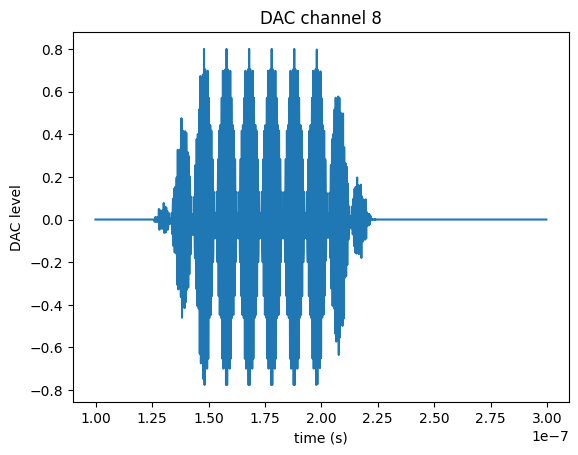

In [35]:
client.plot_dac_out(8, 100.e-9, 300.e-9) 

Text(0.5, 0, 'freq (Hz)')

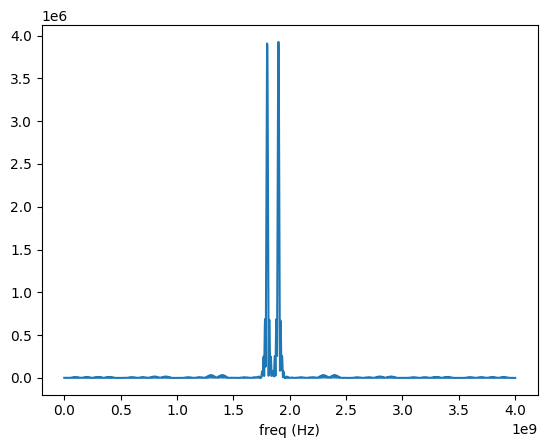

In [36]:
# If we plot an FFT of the above signal we can see both frequency components:
fftfreq = np.fft.rfftfreq(len(client.dac_out[8]), 0.125e-9)
rdrv_fft = np.fft.rfft(client.dac_out[8])
plt.plot(fftfreq, np.abs(rdrv_fft))
plt.xlabel('freq (Hz)') 

### Readout Demodulation

In [37]:
circuit = [{'name': 'pulse', 'phase': 0, 'freq': 6100.e6, 'amp': 0.6, 'twidth': 1e-07,
     'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
     'dest': 'Q0.rdlo'}] 

In [38]:
compiled_prog = tc.run_compile_stage(circuit, fpga_config, qchip)
asm_prog = tc.run_assemble_stage(compiled_prog, channel_configs) 

In [39]:
client.run_program(asm_prog, sim_time=500.e-9) 

In [40]:
client.acc 

[array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([0.+0.j])]

Simulate ADC signal

In [41]:
adc_dt = 0.5e-9 # ADC sample rate is 2 GHz
freq = 6100.e6 # we want to frequency-match the RDLO pulse to properly downconvert to baseband

adc_stream = 0.9*np.cos(2*np.pi * freq * adc_dt * np.arange(1000)) #create a 1000 sample stream

client.run_program(asm_prog, sim_time=500.e-9, adc_stream=adc_stream) 

In [42]:
client.acc 

[array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([410162.-1263130.j])]

## Branching/Feedforward using Mid-circuit Measurements

### Function Processor Channel

In [43]:
fpga_config.fproc_channels

{'Q0.meas': FPROCChannel(id=('Q0.rdlo', 'core_ind'), hold_after_chans=['Q0.rdlo'], hold_nclks=64),
 'Q1.meas': FPROCChannel(id=('Q1.rdlo', 'core_ind'), hold_after_chans=['Q1.rdlo'], hold_nclks=64),
 'Q2.meas': FPROCChannel(id=('Q2.rdlo', 'core_ind'), hold_after_chans=['Q2.rdlo'], hold_nclks=64),
 'Q3.meas': FPROCChannel(id=('Q3.rdlo', 'core_ind'), hold_after_chans=['Q3.rdlo'], hold_nclks=64),
 'Q4.meas': FPROCChannel(id=('Q4.rdlo', 'core_ind'), hold_after_chans=['Q4.rdlo'], hold_nclks=64),
 'Q5.meas': FPROCChannel(id=('Q5.rdlo', 'core_ind'), hold_after_chans=['Q5.rdlo'], hold_nclks=64),
 'Q6.meas': FPROCChannel(id=('Q6.rdlo', 'core_ind'), hold_after_chans=['Q6.rdlo'], hold_nclks=64),
 'Q7.meas': FPROCChannel(id=('Q7.rdlo', 'core_ind'), hold_after_chans=['Q7.rdlo'], hold_nclks=64)}

### Circuit with Branching

Measure qubit 0, if outcome is 1, apply X90 pulse on qubit 1

In [44]:
circuit = [
    {'name': 'read', 'qubit': 'Q0'}, #use a read gate, which includes an rdrv pulse followed by an rdlo pulse
    {'name': 'branch_fproc', 'alu_cond': 'eq', 'cond_lhs': 1, 'func_id': 'Q0.meas', 'scope': ['Q0'], 
     'true': [
         {'name': 'X90', 'qubit':'Q0'}], 
     'false': []}]
 

In [45]:
compiled_prog = tc.run_compile_stage(circuit, fpga_config, qchip)
asm_prog = tc.run_assemble_stage(compiled_prog, channel_configs) 

In [46]:
compiled_prog.program 

{('Q0.qdrv', 'Q0.rdrv', 'Q0.rdlo'): [{'op': 'phase_reset'},
  {'op': 'pulse',
   'freq': 6100000000.0,
   'phase': 0.0,
   'amp': 0.01967670502549965,
   'env': {'env_func': 'cos_edge_square',
    'paradict': {'ramp_fraction': 0.25, 'twidth': 2e-06}},
   'start_time': 5,
   'dest': 'Q0.rdrv',
   'tag': 'Q0read'},
  {'op': 'pulse',
   'freq': 6100000000.0,
   'phase': 1.4806632895920675,
   'amp': 1.0,
   'env': {'env_func': 'square',
    'paradict': {'phase': 0.0, 'amplitude': 1.0, 'twidth': 2e-06}},
   'start_time': 305,
   'dest': 'Q0.rdlo',
   'tag': 'Q0read'},
  {'op': 'idle', 'end_time': 1369},
  {'op': 'jump_fproc',
   'in0': 1,
   'alu_op': 'eq',
   'jump_label': 'true_0',
   'func_id': ('Q0.rdlo', 'core_ind')},
  {'op': 'jump_label', 'dest_label': 'false_0'},
  {'op': 'jump_i', 'jump_label': 'end_0'},
  {'op': 'jump_label', 'dest_label': 'true_0'},
  {'op': 'pulse',
   'freq': 4460029188.07884,
   'phase': 0.0,
   'amp': 0.11222212331696187,
   'env': {'env_func': 'cos_edge_squ

We still have to define the ADC signal ourselves. This is a ADC stream that if the measurement outcome is 0

In [47]:
# Define an ADC stream

adc_dt = 0.5e-9 # ADC sample rate is 2 GHz
freq = 6100.e6 # we want to frequency-match the RDLO pulse to properly downconvert to baseband

adc_stream = 0.9*np.cos(2*np.pi * freq * adc_dt * np.arange(5000)) #create a 5000 sample stream 

In [48]:
# run the program, and check the acc result
client.run_program(asm_prog, sim_time=5.e-6, adc_stream=adc_stream) 

In [49]:
client.acc 

[array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([50998859.+11551333.j])]

No pulse on qubit 0

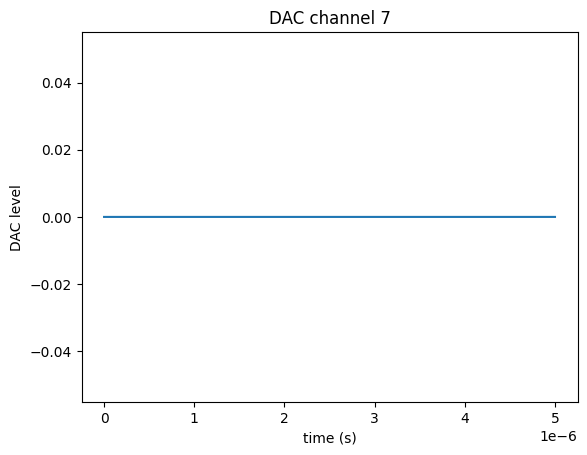

In [50]:
client.plot_dac_out(channel_configs['Q0.qdrv'].core_ind) 

If the measurement outcome is 1, apply X90 pulse on qubit 0

In [51]:
adc_stream = 0.9*np.cos(2*np.pi * freq * adc_dt * np.arange(5000) + np.pi) #create a 5000 sample stream
client.run_program(asm_prog, sim_time=5.e-6, adc_stream=adc_stream)
client.acc 

[array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([-50905771.-11598441.j])]

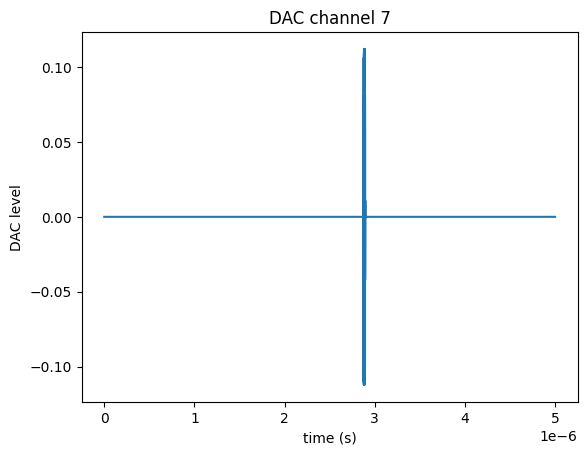

In [52]:
client.plot_dac_out(channel_configs['Q0.qdrv'].core_ind) # check for the pulse out 

## Other Instructions

Loop: Repeat the same pulse multiple times

In [53]:
# repeat a Q0 drive pulse 10 times:
circuit = [
    {'name': 'declare', 'var': 'loop_ind', 'scope': ['Q0']},
    {'name': 'set_var', 'value': 0, 'var': 'loop_ind'},
    #{'name': 'delay', 't': 10.e-9},
    {'name': 'loop', 'cond_lhs': 10, 'alu_cond': 'ge', 'cond_rhs': 'loop_ind', 'scope': ['Q0'], 
     'body': [
         {'name': 'X90', 'qubit': 'Q0'},
         {'name': 'alu', 'op': 'add', 'lhs': 1, 'rhs': 'loop_ind', 'out': 'loop_ind'}
     ]}] 

In [54]:
compiled_prog = tc.run_compile_stage(circuit, fpga_config, qchip)
asm_prog = tc.run_assemble_stage(compiled_prog, channel_configs)
compiled_prog.program 

Z-phase resolution inside loops not supported, be careful!


{('Q0.qdrv', 'Q0.rdrv', 'Q0.rdlo'): [{'op': 'phase_reset'},
  {'op': 'declare_reg', 'name': 'loop_ind', 'dtype': 'int'},
  {'op': 'reg_alu',
   'in0': 0,
   'in1_reg': 'loop_ind',
   'alu_op': 'id0',
   'out_reg': 'loop_ind'},
  {'op': 'jump_label', 'dest_label': 'loop_0_loopctrl'},
  {'op': 'pulse',
   'freq': 4460029188.07884,
   'phase': 0.0,
   'amp': 0.11222212331696187,
   'env': {'env_func': 'cos_edge_square',
    'paradict': {'ramp_fraction': 0.25, 'twidth': 2.4e-08}},
   'start_time': 9,
   'dest': 'Q0.qdrv',
   'tag': 'Q0X90'},
  {'op': 'reg_alu',
   'in0': 1,
   'in1_reg': 'loop_ind',
   'alu_op': 'add',
   'out_reg': 'loop_ind'},
  {'op': 'inc_qclk', 'in0': -20},
  {'op': 'jump_cond',
   'in0': 10,
   'alu_op': 'ge',
   'jump_label': 'loop_0_loopctrl',
   'in1_reg': 'loop_ind'},
  {'op': 'done_stb'}]}

In [55]:
client.run_program(asm_prog, sim_time=1.e-6) 

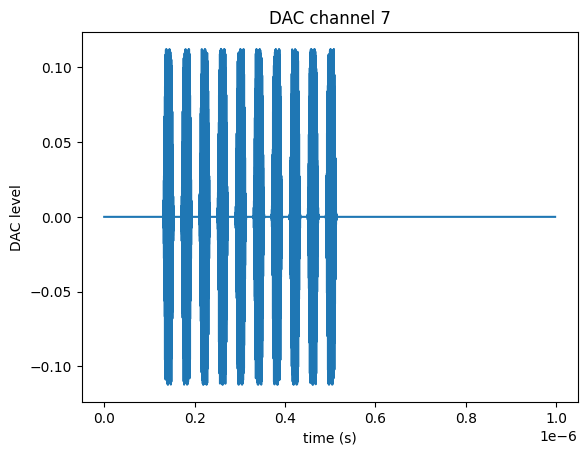

In [56]:
client.plot_dac_out(channel_configs['Q0.qdrv'].core_ind) 

Fast Amplitude Sweep

In [57]:
# sweep Q0.drive amplitude:
circuit = [
    {'name': 'declare', 'var': 'loop_ind', 'scope': ['Q0']},
    {'name': 'set_var', 'value': 0, 'var': 'loop_ind'},
    {'name': 'declare', 'var': 'amp', 'scope': ['Q0'], 'dtype': 'amp'},
    {'name': 'set_var', 'value': 0.1, 'var': 'amp'}, # pulse amplitude is parameterized by processor register
    {'name': 'loop', 'cond_lhs': 10, 'alu_cond': 'ge', 'cond_rhs': 'loop_ind', 'scope': ['Q0'], 
     'body': [
            {'name': 'pulse', 'phase': 0, 'freq': 4944383311, 'amp': 'amp', 'twidth': 2.4e-08,
             'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
             'dest': 'Q0.qdrv'},
         {'name': 'alu', 'op': 'add', 'lhs': 1, 'rhs': 'loop_ind', 'out': 'loop_ind'},
         {'name': 'alu', 'op': 'add', 'lhs': 0.1, 'rhs': 'amp', 'out': 'amp'}

         
     ]}] 

In [58]:
compiled_prog = tc.run_compile_stage(circuit, fpga_config, qchip)
asm_prog = tc.run_assemble_stage(compiled_prog, channel_configs)
compiled_prog.program 

Z-phase resolution inside loops not supported, be careful!


{('Q0.qdrv', 'Q0.rdrv', 'Q0.rdlo'): [{'op': 'phase_reset'},
  {'op': 'declare_reg', 'name': 'loop_ind', 'dtype': 'int'},
  {'op': 'reg_alu',
   'in0': 0,
   'in1_reg': 'loop_ind',
   'alu_op': 'id0',
   'out_reg': 'loop_ind'},
  {'op': 'declare_reg', 'name': 'amp', 'dtype': 'amp'},
  {'op': 'reg_alu',
   'in0': 0.1,
   'in1_reg': 'amp',
   'alu_op': 'id0',
   'out_reg': 'amp'},
  {'op': 'jump_label', 'dest_label': 'loop_0_loopctrl'},
  {'op': 'pulse',
   'freq': 4944383311,
   'phase': 0,
   'amp': 'amp',
   'env': {'env_func': 'cos_edge_square',
    'paradict': {'ramp_fraction': 0.25, 'twidth': 2.4e-08}},
   'start_time': 13,
   'dest': 'Q0.qdrv'},
  {'op': 'reg_alu',
   'in0': 1,
   'in1_reg': 'loop_ind',
   'alu_op': 'add',
   'out_reg': 'loop_ind'},
  {'op': 'reg_alu',
   'in0': 0.1,
   'in1_reg': 'amp',
   'alu_op': 'add',
   'out_reg': 'amp'},
  {'op': 'inc_qclk', 'in0': -28},
  {'op': 'jump_cond',
   'in0': 10,
   'alu_op': 'ge',
   'jump_label': 'loop_0_loopctrl',
   'in1_reg':

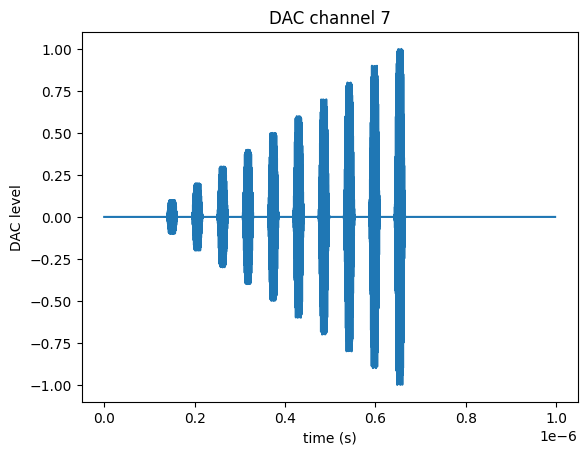

In [59]:
client.run_program(asm_prog, sim_time=1.e-6)
client.plot_dac_out(channel_configs['Q0.qdrv'].core_ind) 

Fast Frequency Sweep

In [60]:
# Need to declare all frequencies at compile-time, since they are stored as pre-computed phase offsets in memory, and accessed by address
freqs = np.linspace(0, 10.e6, 11) 
circuit = [{'name': 'declare_freq', 'freq': freq, 'scope': ['Q0.qdrv'], 'freq_ind': i} 
           for i, freq in enumerate(freqs)]

circuit.extend([
    {'name': 'declare', 'var': 'freq_ind', 'scope': ['Q0'], 'dtype': 'int'}, # parameterize the frequency using an index 
    {'name': 'set_var', 'value': 0, 'var': 'freq_ind'},
    {'name': 'loop', 'cond_lhs': len(freqs), 'alu_cond': 'ge', 'cond_rhs': 'freq_ind', 'scope': ['Q0'], 
              'body': [

                    {'name': 'delay', 't': 30.e-8},
                  
                    {'name': 'pulse', 'phase': 0, 'freq': 'freq_ind', 'amp': 0.9, 'twidth': 100e-08,
                         'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
                         'dest': 'Q0.qdrv'},
                  
                    #{'name': 'read', 'qubit': 'Q0'},
                
                    {'name': 'alu', 'op': 'add', 'lhs': 1, 'rhs': 'freq_ind', 'out': 'freq_ind'},

                  
            ]}]) 

In [61]:
compiled_prog = tc.run_compile_stage(circuit, fpga_config, qchip)
asm_prog = tc.run_assemble_stage(compiled_prog, channel_configs) 

Z-phase resolution inside loops not supported, be careful!


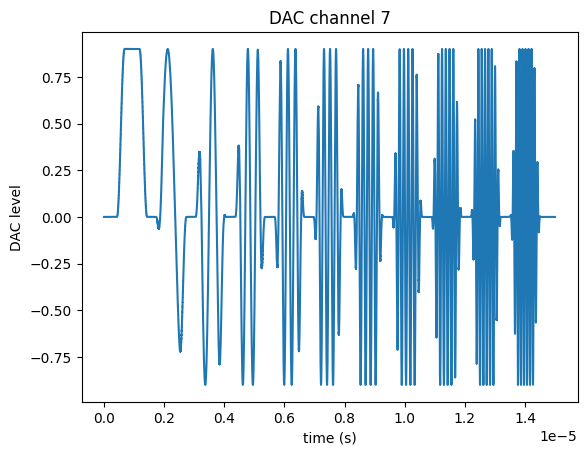

In [62]:
client.run_program(asm_prog, sim_time=15.e-6)
client.plot_dac_out(channel_configs['Q0.qdrv'].core_ind) 

Compound Freq x Amplitude Sweep

In [63]:
amp_start = 0.1
amp_stop = 0.5
amp_step = 0.1

freqs = np.linspace(0, 10.e6, 5) # frequencies can be an arbitrary array, 
                                          # since we're storing them in a table and accessing the address

# first, declare all frequencies
circuit = [{'name': 'declare_freq', 'freq': freq, 'scope': ['Q0.qdrv'], 'freq_ind': i} 
           for i, freq in enumerate(freqs)]

# fill in the rest of the circuit
circuit.extend([
    {'name': 'declare', 'var': 'amp', 'scope': ['Q0'], 'dtype': 'amp'},
    {'name': 'set_var', 'value': amp_start, 'var': 'amp'}, # pulse amplitude is parameterized by processor register
    
    {'name': 'declare', 'var': 'freq_ind', 'scope': ['Q0'], 'dtype': 'int'}, # frequency index is parameterized by a register
    
    # outer loop over amplitude
    {'name': 'loop', 'cond_lhs': amp_stop, 'alu_cond': 'ge', 'cond_rhs': 'amp', 'scope': ['Q0'], 
     'body': [
         {'name': 'set_var', 'value': 0, 'var': 'freq_ind'},
         #{'name': 'alu', 'op': 'add', 'lhs': 2, 'rhs': 'freq_ind', 'out': 'freq_ind'},

         # inner loop over frequency
         {'name': 'loop', 'cond_lhs': len(freqs), 'alu_cond': 'ge', 'cond_rhs': 'freq_ind', 'scope': ['Q0'], 
              'body': [

                    {'name': 'delay', 't': 100.e-9},
                  
                    {'name': 'pulse', 'phase': 0, 'freq': 'freq_ind', 'amp': 'amp', 'twidth': 50e-08,
                         'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
                         'dest': 'Q0.qdrv'},
                  
                    #{'name': 'read', 'qubit': 'Q0'},
                
                    {'name': 'alu', 'op': 'add', 'lhs': 1, 'rhs': 'freq_ind', 'out': 'freq_ind'},

                  
            ]},
         {'name': 'alu', 'op': 'add', 'lhs': amp_step, 'rhs': 'amp', 'out': 'amp'},

        ]
    }
]) 

In [64]:
compiled_prog = tc.run_compile_stage(circuit, fpga_config, qchip)
asm_prog = tc.run_assemble_stage(compiled_prog, channel_configs)
#compiled_prog.program 

Z-phase resolution inside loops not supported, be careful!
Z-phase resolution inside loops not supported, be careful!
/distributed_processor/python/distproc/assembler.py:117: UserWarning: {'op': 'pulse', 'freq': 'freq_ind', 'phase': 0, 'amp': 'amp', 'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25, 'twidth': 5e-07}}, 'start_time': 63, 'dest': 'Q0.qdrv', 'label': 'loop_body_loop_0_loopctrl'} will be split into multiple instructions, which may cause timing problems
  warnings.warn(


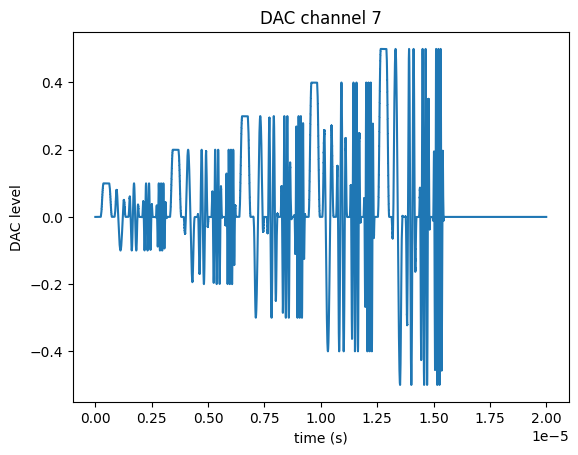

In [65]:
client.run_program(asm_prog, sim_time=20.e-6)
client.plot_dac_out(channel_configs['Q0.qdrv'].core_ind) 

Combine Branching and Looping

In [66]:
rdlo_freq = 6100000000
circuit = [
    # initialize variables:
    {'name': 'declare', 'var': 'loop_ind', 'scope': ['Q0']},
    {'name': 'set_var', 'value': 0, 'var': 'loop_ind'},
    {'name': 'declare', 'var': 'amp', 'scope': ['Q0'], 'dtype': 'amp'},
    {'name': 'set_var', 'value': 0.1, 'var': 'amp'}, # pulse amplitude is parameterized by processor register
    
    {'name': 'loop', 'cond_lhs': 5, 'alu_cond': 'ge', 'cond_rhs': 'loop_ind', 'scope': ['Q0'], 
     'body': [
         

         # read (rdlo pulse):
        {'name': 'pulse', 'phase': 0, 'freq': rdlo_freq, 'amp': 0.9, 'twidth': 1.e-7,
         'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
         'dest': 'Q0.rdlo'},
         
        
         # Fill in branch_fproc + conditional amplitude increment here:
         {'name': 'branch_fproc', 'cond_lhs': 1, 'alu_cond': 'eq', 'func_id': 'Q0.meas',
          'true':[
              {'name': 'alu', 'op': 'add', 'lhs': 0.1, 'rhs': 'amp', 'out': 'amp'}
          ],
          'false': [], 'scope': ['Q0']},
         
         
         # pulse:
         {'name': 'pulse', 'phase': 0, 'freq': 4944383311, 'amp': 'amp', 'twidth': 2.4e-08,
           'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
           'dest': 'Q0.qdrv'},

         # increment loop counter
         {'name': 'alu', 'op': 'add', 'lhs': 1, 'rhs': 'loop_ind', 'out': 'loop_ind'}
     ]

         
     }] 

In [67]:
compiled_prog = tc.run_compile_stage(circuit, fpga_config, qchip)
asm_prog = tc.run_assemble_stage(compiled_prog, channel_configs)
compiled_prog.program 

Z-phase resolution inside loops not supported, be careful!


{('Q0.qdrv', 'Q0.rdrv', 'Q0.rdlo'): [{'op': 'phase_reset'},
  {'op': 'declare_reg', 'name': 'loop_ind', 'dtype': 'int'},
  {'op': 'reg_alu',
   'in0': 0,
   'in1_reg': 'loop_ind',
   'alu_op': 'id0',
   'out_reg': 'loop_ind'},
  {'op': 'declare_reg', 'name': 'amp', 'dtype': 'amp'},
  {'op': 'reg_alu',
   'in0': 0.1,
   'in1_reg': 'amp',
   'alu_op': 'id0',
   'out_reg': 'amp'},
  {'op': 'jump_label', 'dest_label': 'loop_0_loopctrl'},
  {'op': 'pulse',
   'freq': 6100000000,
   'phase': 0,
   'amp': 0.9,
   'env': {'env_func': 'cos_edge_square',
    'paradict': {'ramp_fraction': 0.25, 'twidth': 1e-07}},
   'start_time': 13,
   'dest': 'Q0.rdlo'},
  {'op': 'idle', 'end_time': 127},
  {'op': 'jump_fproc',
   'in0': 1,
   'alu_op': 'eq',
   'jump_label': 'loop_body_true_0',
   'func_id': ('Q0.rdlo', 'core_ind')},
  {'op': 'jump_label', 'dest_label': 'loop_body_false_0'},
  {'op': 'jump_i', 'jump_label': 'loop_body_end_0'},
  {'op': 'jump_label', 'dest_label': 'loop_body_true_0'},
  {'op': 

In [69]:
adc_stream = 0.9*np.cos(2*np.pi * (rdlo_freq - 3.e6) * adc_dt * np.arange(5000) + np.pi) #offset the frequency to sample different parts of IQ plane
client.run_program(asm_prog, sim_time=2.e-6, adc_stream=adc_stream)
client.acc 

[array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([], dtype=complex128),
 array([ 1359361.-1209431.j,   650694.-1698660.j,  -201894.-1807797.j,
        -1010725.-1512793.j, -1593931. -878263.j])]

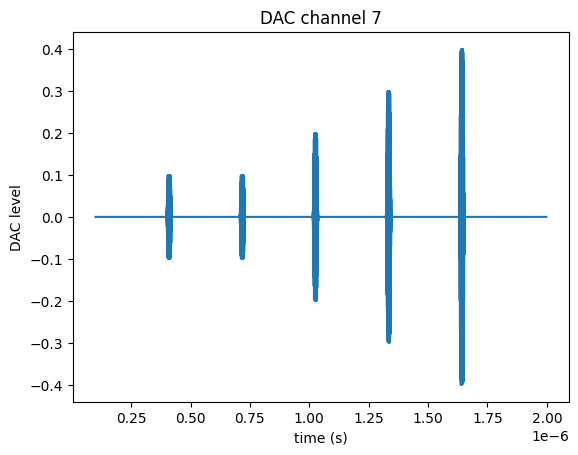

In [70]:
client.plot_dac_out(channel_configs['Q0.qdrv'].core_ind, start_time=100.e-9) 

## Different Pulse Shapes and pulse data

All was in https://gitlab.com/LBL-QubiC/experiments/qubitconfig/-/blob/main/qubitconfig/envelope_pulse.py?ref_type=heads, you can even define your own pulse shape.

In [71]:
circuit = [
    #play a single pulse on the Q0 drive channel
    {'name': 'pulse', 'phase': 0, 'freq': 4944383311, 'amp': 0.334704954261188, 'twidth': 2.4e-08,
     'env': {'env_func': 'square', 'paradict': {'amplitude': 0.1}},
     'dest': 'Q0.qdrv'}, 
    
] 

In [72]:
compiled_prog = tc.run_compile_stage(circuit, fpga_config, None, compiler_flags=CompilerFlags(resolve_gates=False))
compiled_prog.program 

{('Q0.qdrv', 'Q0.rdrv', 'Q0.rdlo'): [{'op': 'phase_reset'},
  {'op': 'pulse',
   'freq': 4944383311,
   'phase': 0,
   'amp': 0.334704954261188,
   'env': {'env_func': 'square',
    'paradict': {'amplitude': 0.1, 'twidth': 2.4e-08}},
   'start_time': 5,
   'dest': 'Q0.qdrv'},
  {'op': 'done_stb'}]}

In [73]:
asm_prog = tc.run_assemble_stage(compiled_prog, channel_configs) 

In [74]:
client.run_program(asm_prog, sim_time=150.e-9) 

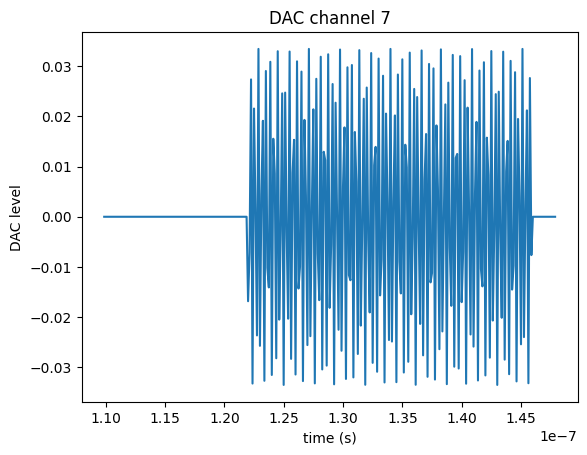

In [75]:
client.plot_dac_out(channel_configs['Q0.qdrv'].core_ind, 110.e-9, 150.e-9) 

Pulse data

In [76]:
print(client.dac_out[channel_configs['Q0.qdrv'].core_ind, int(120.e-9//(1/8.e9)):(int(150.e-9//(1/8.e9)))])

[    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.  -551.  -235.   896.
 -1088.   706.    44.  -774.  1095.  -842.   146.   626. -1070.   951.
  -333.  -461.  1011. -1032.   509.   280.  -923.  1080.  -671.   -92.
   805. -1097.   810.  -100.  -665.  1078.  -927.   287.   502. -1029.
  1014.  -468.  -326.   947. -1072.   632.   138.  -837.  1095.  -779.
    52.   701. -1087.   900.  -242.  -544.  1044.  -996.   424.   369.
  -971.  1060.  -594.  -185.   866. -1093.   744.    -6.  -737.  1091.
  -874.   196.   583. -1058.   975.  -381.  -414.   990. -1048.   553.
   230.  -895.  1087.  -710.   -42.   770. -1096.   843.  -150.  -624.
  1068.  -953.   336.   456. -1011.  1032.  -513.  -277.   920. -1081.
   673.    88.  -804.  1095.  -814.   103.   661. -1079.   928.  -292.
  -500.  1027. -1016.   470.   321.  -946.  1071.  -636.  -135.   834.
 -1096.   781.   -57.  -699.  1085.  -904.   245.   540. -1044.   997.
  -428